# **Introduction**

This tutorial demonstrates a critical business scenario: a user lands on a website, and a marketing engine must decide which specific ad to display from an inventory of thousands.
The goal is to maximize the Click-Through Rate (CTR). Showing irrelevant ads wastes marketing budget and annoys the user. Therefore, we need a system that predicts the probability of a specific user clicking on a specific ad based on their demographics and browsing habits.

**Architecture**
1. **The Retrieval Stage:** Efficiently select an initial set of roughly 10-100 candidates from millions of possibilities. It weeds out items the user is definitely not interested in.
User Tower: Embeds user features (ID, demographics, behavior) into a vector.
Item Tower: Embeds ad features (Ad ID, Topic) into a vector.
Interaction: The dot product of these two vectors represents similarity.
2. **The Ranking Stage:** It takes the output of the retrieval model and fine-tune the order to select the single best ad to show.
A Deep Neural Network (MLP).
Interaction: It takes the User Embedding, Ad Embedding, and their similarity score to predict a precise probability (0% to 100%) that the user will click.

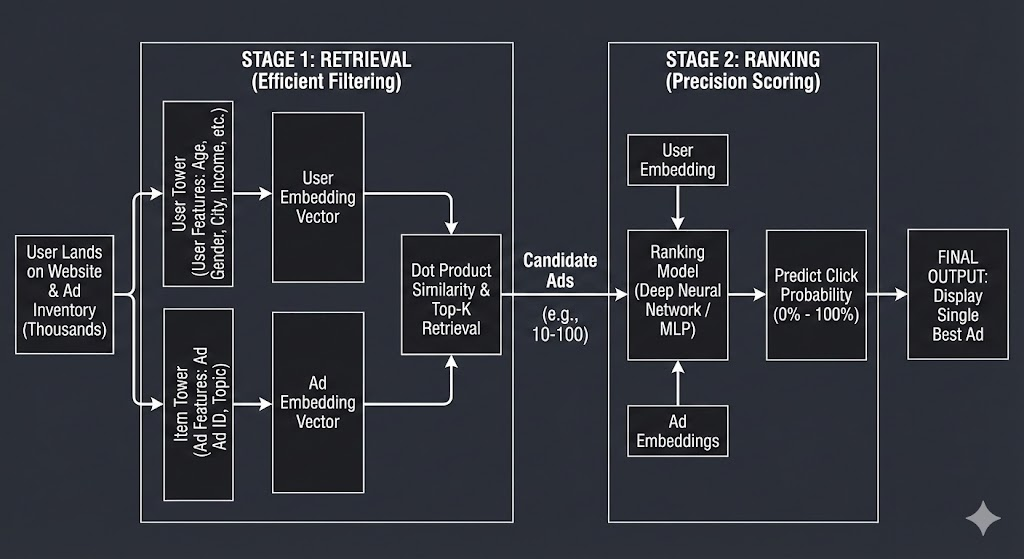

# **Dataset**
We will use the [Ad Click Prediction](https://www.kaggle.com/datasets/mafrojaakter/ad-click-data) Dataset from Kaggle

**Feature Distribution of dataset:**
User Tower describes who is looking and features contains i.e Gender, City, Country, Age, Daily Internet Usage, Daily Time Spent on Site, and Area Income.
Item Tower describes what is being shown and features contains Ad Topic Line, Ad ID.

In this tutorial, we are going to build and train a Two-Tower (User Tower and Ad Tower) model using the Ad Click Prediction dataset from Kaggle.
We're going to:
1. **Data Pipeline:** Get our data and preprocess it for both Retrieval (implicit feedback) and Ranking (explicit labels).
2. **Retrieval:** Implement and train a Two-Tower model to generate candidates.
3. **Ranking:** Implement and train a Neural Ranking model to predict click probabilities.
4. **Inference:** Run an end-to-end test (Retrieval --> Ranking) to generate recommendations for a specific user.

In [1]:
!pip install -q keras-rs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 2.8 MB/s eta 0:00:00


In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import keras_rs
import tensorflow_datasets as tfds
from mpl_toolkits.axes_grid1 import make_axes_locatable
from keras import layers
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler



# **Preparing Dataset**

In [3]:
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"mansim071","key":"7b9249c264ac5cb7d295afcdd44f7ad1"}'}

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d mafrojaakter/ad-click-data
!unzip -o ad-click-data.zip -d ./ad_click_data

Dataset URL: https://www.kaggle.com/datasets/mafrojaakter/ad-click-data
License(s): unknown
  0% 0.00/37.6k [00:00<?, ?B/s]
100% 37.6k/37.6k [00:00<00:00, 138MB/s]
Archive:  ad-click-data.zip
  inflating: ./ad_click_data/Ad Click Data.csv  


In [6]:
ads_df= pd.read_csv('/content/ad_click_data/Ad Click Data.csv')
# Clean column names
ads_df.columns = ads_df.columns.str.strip()
# Rename the column name
ads_df = ads_df.rename(columns={
    'Male': 'gender',
    'Ad Topic Line': 'ad_topic',
    'City': 'city',
    'Country': 'country',
    'Daily Time Spent on Site': 'time_on_site',
    'Daily Internet Usage': 'internet_usage',
    'Area Income': 'area_income'
})
#Add user_id and add_id column
ads_df['user_id'] = "user_" + ads_df.index.astype(str)
ads_df['ad_id'] = "ad_" + ads_df['ad_topic'].astype('category').cat.codes.astype(str)
# Remove nulls and normalize
ads_df = ads_df.dropna()
#normalize
numeric_cols = ["time_on_site", "internet_usage", "area_income", "Age"]
scaler = MinMaxScaler()
ads_df[numeric_cols] = scaler.fit_transform(ads_df[numeric_cols])

In [7]:
#Split the train and test datasets
x_train,x_test= train_test_split(ads_df,test_size=0.2,random_state=42)

In [28]:
def dict_to_tensor_features(df_features, continuous_features):
    tensor_dict = {}
    for k, v in df_features.items():
        if k in continuous_features:
            tensor_dict[k] = tf.expand_dims(tf.constant(v, dtype='float32'), axis=-1)
        else:
            v_str = np.array(v).astype(str).tolist()
            tensor_dict[k] = tf.expand_dims(tf.constant(v_str, dtype='string'), axis=-1)
    return tensor_dict

def create_retrieval_dataset(data_df,all_ads_features,all_ad_ids,
                             user_features_list,ad_features_list,continuous_features_list):

    # Filter for Positive Interactions (Cicks)
    positive_interactions = data_df[data_df["Clicked on Ad"] == 1].copy()

    if positive_interactions.empty:
        return None

    def sample_negative(positive_ad_id):
        neg_ad_id = positive_ad_id
        while neg_ad_id == positive_ad_id:
            neg_ad_id = np.random.choice(all_ad_ids)
        return neg_ad_id

    def create_triplets_row(pos_row):
        pos_ad_id = pos_row.ad_id
        neg_ad_id = sample_negative(pos_ad_id)

        neg_ad_row = all_ads_features[all_ads_features['ad_id'] == neg_ad_id].iloc[0]
        user_features_dict = {name: getattr(pos_row, name) for name in user_features_list}
        pos_ad_features_dict = {name: getattr(pos_row, name) for name in ad_features_list}
        neg_ad_features_dict = {name: neg_ad_row[name] for name in ad_features_list}

        return {
            "user": user_features_dict,
            "positive_ad": pos_ad_features_dict,
            "negative_ad": neg_ad_features_dict
        }

    with ThreadPoolExecutor(max_workers=8) as executor:
        triplets = list(executor.map(create_triplets_row, positive_interactions.itertuples(index=False)))

    triplets_df = pd.DataFrame(triplets)
    user_df = triplets_df["user"].apply(pd.Series)
    pos_ad_df = triplets_df["positive_ad"].apply(pd.Series)
    neg_ad_df = triplets_df["negative_ad"].apply(pd.Series)

    user_features_tensor = dict_to_tensor_features(user_df.to_dict('list'), continuous_features_list)
    pos_ad_features_tensor = dict_to_tensor_features(pos_ad_df.to_dict('list'), continuous_features_list)
    neg_ad_features_tensor = dict_to_tensor_features(neg_ad_df.to_dict('list'), continuous_features_list)

    features = {
        "user": user_features_tensor,
        "positive_ad": pos_ad_features_tensor,
        "negative_ad": neg_ad_features_tensor,
    }
    y_true = tf.ones((triplets_df.shape[0], 1), dtype=tf.float32)
    dataset = tf.data.Dataset.from_tensor_slices((features, y_true))
    buffer_size = len(triplets_df)
    dataset = dataset.shuffle(buffer_size=buffer_size).batch(64).cache().prefetch(tf.data.AUTOTUNE)
    return dataset

user_clicked_ads = (
    x_train[x_train["Clicked on Ad"] == 1]
    .groupby("user_id")["ad_id"]
    .apply(set)
    .to_dict()
)

for u in x_train["user_id"].unique():
    if u not in user_clicked_ads:
        user_clicked_ads[u] = set()

AD_FEATURES = ["ad_id", "ad_topic"]
USER_FEATURES = ["user_id", "gender", "city", "country", "time_on_site", "internet_usage", "area_income", "Age"]
continuous_features = ["time_on_site", "internet_usage", "area_income", "Age"]

all_ads_features = x_train[AD_FEATURES].drop_duplicates().reset_index(drop=True)
all_ad_ids = all_ads_features['ad_id'].tolist()

retrieval_train_dataset = create_retrieval_dataset(
    data_df=x_train,
    all_ads_features=all_ads_features,
    all_ad_ids=all_ad_ids,
    user_features_list=USER_FEATURES,
    ad_features_list=AD_FEATURES,
    continuous_features_list=continuous_features
)

retrieval_test_dataset = create_retrieval_dataset(
    data_df=x_test,
    all_ads_features=all_ads_features,
    all_ad_ids=all_ad_ids,
    user_features_list=USER_FEATURES,
    ad_features_list=AD_FEATURES,
    continuous_features_list=continuous_features
)

# **Implement the Retrival Model**
For the Retrieval stage, we will build a Two-Tower Model.

**The Architecture Components:**

1. User Tower:User features (User ID, demographics, behavior metrics like time_on_site). It encodes these mixed features into a fixed-size vector representation called the User Embedding.
2. Item (Ad) Tower:Ad features (Ad ID, Ad Topic Line).It encodes these features into a fixed-size vector representation called the Item Embedding.
3. Interaction (Similarity):We calculate the Dot Product between the User Embedding and the Item Embedding.

In [29]:
keras.utils.set_random_seed(42)

In [30]:
vocab_map = {
    "user_id": x_train["user_id"].unique(),
    "gender": x_train["gender"].astype(str).unique(),
    "city": x_train["city"].unique(),
    "country": x_train["country"].unique(),
    "ad_id": x_train["ad_id"].unique(),
    "ad_topic": x_train["ad_topic"].unique()
}
cont_feats = ["time_on_site", "internet_usage", "area_income", "Age"]

normalizers = {}
for f in cont_feats:
    norm = layers.Normalization(axis=None)
    norm.adapt(x_train[f].values.astype('float32'))
    normalizers[f] = norm

def build_tower(feature_names, continuous_names=None, embed_dim=64, name="tower"):
    inputs, embeddings = {}, []

    for feat in feature_names:
        if feat in vocab_map:
            inp = keras.Input(shape=(1,), dtype=tf.string, name=feat)
            inputs[feat] = inp
            vocab = list(vocab_map[feat])
            x = layers.StringLookup(vocabulary=vocab)(inp)
            x = layers.Embedding(len(vocab) + 1, embed_dim, embeddings_regularizer='l2')(x)
            embeddings.append(layers.Flatten()(x))

    if continuous_names:
        for feat in continuous_names:
            inp = keras.Input(shape=(1,), dtype=tf.float32, name=feat)
            inputs[feat] = inp
            embeddings.append(normalizers[feat](inp))

    x = layers.Concatenate()(embeddings)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation="relu")(x)
    output = layers.Dense(embed_dim)(layers.Dropout(0.2)(x))

    return keras.Model(inputs=inputs, outputs=output, name=name)

In [31]:
user_tower = build_tower(["user_id", "gender", "city", "country"], cont_feats, name="user_tower")
ad_tower = build_tower(["ad_id", "ad_topic"], name="ad_tower")

In [32]:
def bpr_hinge_loss(y_true, y_pred):
    margin = 1.0
    return -tf.math.log(tf.nn.sigmoid(y_pred) + 1e-10)

In [33]:
class RetrievalModel(keras.Model):
  def __init__(self, user_tower_instance, ad_tower_instance, **kwargs):
    super().__init__(**kwargs)
    self.user_tower = user_tower
    self.ad_tower = ad_tower
    self.ln_user = layers.LayerNormalization()
    self.ln_ad = layers.LayerNormalization()


  def call(self,inputs):
    u_emb = self.ln_user(self.user_tower(inputs["user"]))
    pos_emb = self.ln_ad(self.ad_tower(inputs["positive_ad"]))
    neg_emb = self.ln_ad(self.ad_tower(inputs["negative_ad"]))
    pos_score = keras.ops.sum(u_emb * pos_emb, axis=1, keepdims=True)
    neg_score = keras.ops.sum(u_emb * neg_emb, axis=1, keepdims=True)
    return pos_score - neg_score


  def get_embeddings(self, inputs):
    u_emb = self.ln_user(self.user_tower(inputs["user"]))
    ad_emb = self.ln_ad(self.ad_tower(inputs["positive_ad"]))
    dot_interaction = keras.ops.sum(u_emb * ad_emb, axis=1, keepdims=True)
    return u_emb, ad_emb, dot_interaction

In [34]:
retrieval_model = RetrievalModel(user_tower, ad_tower)
retrieval_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss=bpr_hinge_loss)
history = retrieval_model.fit(retrieval_train_dataset,epochs=30)

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 2.9548
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3977 
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1149 
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9265 
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7926 
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6924 
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6163 
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5574 
Epoch 9/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5107 
Epoch 10/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4725
Epoch 11/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4401 
Epoch 12/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4120 
Epoch 13/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3869 
Epoch 14/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3644 
Epoch 15/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3438 
Epoch 16/30
6/6 ━━━━━━━━━━━━━━━━━━━

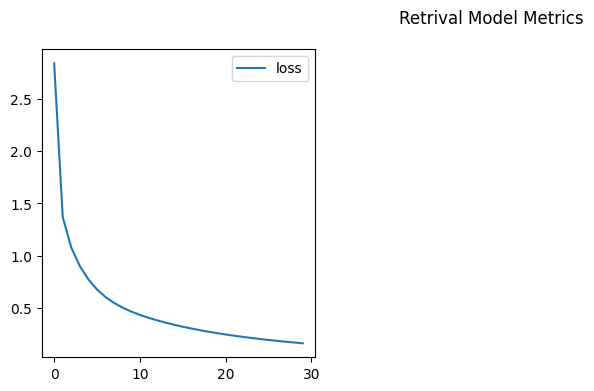

In [37]:
pd.DataFrame(history.history).plot(subplots=True, layout=(1, 3), figsize=(12, 4), title="Retrival Model Metrics")
plt.show()

# **Predictions of Retrival Model**
Two-Tower model is trained, we need to use it to generate candidates.

We can implement inference pipeline using three steps:
1. Indexing: We can run the Item Tower once for all available ads to generate their embeddings.
2. Query Encoding: When a user arrives, we pass their features through the User Tower to generate a User Embedding.
3. Nearest Neighbor Search: We search the index to find the Ad Embeddings closest to the User Embedding (highest dot product).

Keras-RS [BruteForceRetrieval layer](https://keras.io/keras_rs/api/retrieval_layers/brute_force_retrieval/) calculates dot product between the user and every single item in the index to find exact top-K matches

In [51]:
USER_CATEGORICAL = ["user_id", "gender", "city", "country"]
CONTINUOUS_FEATURES = ["time_on_site", "internet_usage", "area_income", "Age"]
USER_FEATURES = USER_CATEGORICAL + CONTINUOUS_FEATURES

class BruteForceRetrievalWrapper:
    def __init__(self, model, ads_df, ad_features, user_features, k=10):
        self.model, self.k = model, k
        self.user_features = user_features
        unique_ads = ads_df[ad_features].drop_duplicates("ad_id").reset_index(drop=True)
        self.ids = unique_ads["ad_id"].values
        self.topic_map = dict(zip(unique_ads["ad_id"], unique_ads["ad_topic"]))
        ad_inputs = {"ad_id": tf.constant(self.ids.astype(str)),
                    "ad_topic": tf.constant(unique_ads["ad_topic"].astype(str).values)
                     }
        self.candidate_embs = model.ln_ad(model.ad_tower(ad_inputs))

    def query_batch(self, user_df):
        inputs = {k: tf.constant(user_df[k].values.astype(float if k in CONTINUOUS_FEATURES else str))
                for k in self.user_features if k in user_df.columns
                }
        u_emb = self.model.ln_user(self.model.user_tower(inputs))
        scores = tf.linalg.matmul(u_emb, self.candidate_embs, transpose_b=True)
        top_scores, top_indices = tf.math.top_k(scores, k=self.k)
        return top_scores.numpy(), top_indices.numpy()

    def decode_results(self, scores, indices):
        results = []
        for row_scores, row_indices in zip(scores, indices):
            retrieved_ids = self.ids[row_indices]
            results.append([
                {"ad_id": aid, "ad_topic": self.topic_map[aid], "score": float(s)}
                for aid, s in zip(retrieved_ids, row_scores)
            ])
        return results

retrieval_engine = BruteForceRetrievalWrapper(model=retrieval_model,ads_df=ads_df,ad_features=["ad_id", "ad_topic"],
                                              user_features=USER_FEATURES,  k=10)
sample_user = pd.DataFrame([x_test.iloc[0]])
scores, indices = retrieval_engine.query_batch(sample_user)
top_ads = retrieval_engine.decode_results(scores, indices)[0]

# **Implementation of Ranking Model**
Retrieval model  only calculates a simple similarity score (Dot Product). It doesn't account for complex feature interactions.
So we need to build ranking model after words retrival model.

**Architecture**
1. **Feature Extraction:** We reuse the trained User Tower and Ad Tower from the Retrieval stage. We freeze these towers (trainable = False) so their weights don't change.
2. **Interaction:** Instead of just a dot product, we concatenate three inputs- The User EmbeddingThe Ad EmbeddingThe Dot Product (Similarity)
3. **Scorer(MLP):** These concatenated inputs are fed into a Multi-Layer Perceptron—a stack of Dense layers. This network learns the non-linear relationships between the user and the ad.
4. **Output:** The final layer uses a Sigmoid activation to output a single probability between 0.0 and 1.0 (Likelihood of a Click).

In [39]:
retrieval_model.trainable = False
def create_ranking_ds(df):
    inputs = {"user": dict_to_tensor_features(df[USER_FEATURES], continuous_features),
              "positive_ad": dict_to_tensor_features(df[AD_FEATURES], continuous_features)
              }
    return tf.data.Dataset.from_tensor_slices((inputs, df["Clicked on Ad"].values.
                                               astype('float32'))).shuffle(10000).batch(256).prefetch(tf.data.AUTOTUNE)

In [40]:
ranking_train_dataset= create_ranking_ds(x_train)
ranking_test_dataset = create_ranking_ds(x_test)

In [41]:
class RankingModel(keras.Model):
    def __init__(self, retrieval_model, **kwargs):
        super().__init__(**kwargs)
        self.retrieval = retrieval_model
        self.mlp = keras.Sequential([
            layers.Dense(256, activation="relu"), layers.Dropout(0.2),
            layers.Dense(128, activation="relu"), layers.Dropout(0.2),
            layers.Dense(64, activation="relu"),
            layers.Dense(1, activation="sigmoid")
        ])

    def call(self, inputs):
        u_emb, ad_emb, dot = self.retrieval.get_embeddings(inputs)
        return self.mlp(keras.ops.concatenate([u_emb, ad_emb, dot], axis=-1))

In [42]:
ranking_model = RankingModel(retrieval_model)
ranking_model.compile(optimizer=keras.optimizers.Adam(1e-4), loss="binary_crossentropy", metrics=["AUC", "accuracy"])
history1 = ranking_model.fit(ranking_train_dataset, epochs=20)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - AUC: 0.7137 - accuracy: 0.4999 - loss: 0.6688
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - AUC: 0.8871 - accuracy: 0.6535 - loss: 0.6237
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - AUC: 0.9528 - accuracy: 0.8104 - loss: 0.5837
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - AUC: 0.9704 - accuracy: 0.8531 - loss: 0.5561 
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - AUC: 0.9826 - accuracy: 0.9023 - loss: 0.5173
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - AUC: 0.9875 - accuracy: 0.9188 - loss: 0.4851
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - AUC: 0.9866 - accuracy: 0.9337 - loss: 0.4533
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.9914 - accuracy: 0.9448 - loss: 0.4224 
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - AUC: 0.9903 - accuracy: 0.9441 - loss: 0.3910
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - AUC: 0.9910 - accuracy: 0.9502 - loss: 0.3671
Epoch 11/20
3/3 ━━━━━━━━━━━

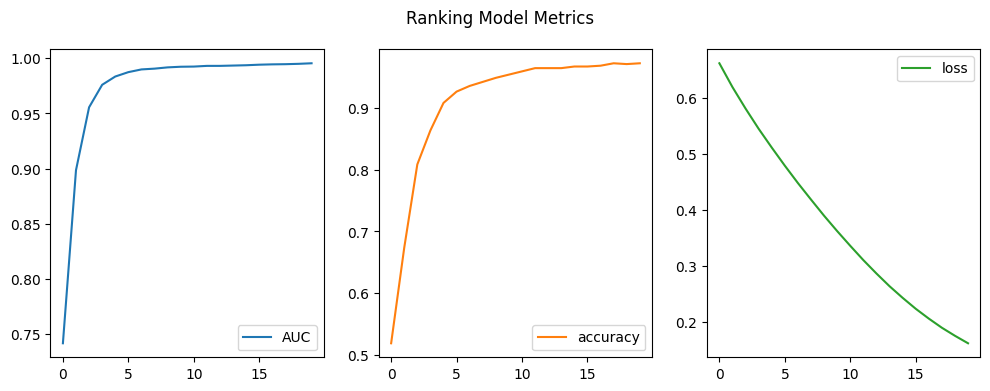

In [43]:
pd.DataFrame(history1.history).plot(subplots=True, layout=(1, 3), figsize=(12, 4), title="Ranking Model Metrics")
plt.show()

In [44]:
ranking_model.evaluate(ranking_test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step - AUC: 0.9867 - accuracy: 0.9372 - loss: 0.2243


[0.2243196964263916, 0.9866776466369629, 0.9371727705001831]

# **Predictions of Ranking Model**
The retrieval model gave us a list of ads that are generally relevant (high dot product similarity). The ranking model will now calculate the specific probability (0% to 100%) that the user will click each of those ads.

The Ranking model expects pairs of (User, Ad). Since we are scoring 10 ads for 1 user, we cannot just pass the user features once.We effectively take user's features 10 times to create a batch.

In [49]:
def rerank_ads_for_user(user_row, retrieved_ads, ranking_model):
    ads_df = pd.DataFrame(retrieved_ads)
    num_ads = len(ads_df)
    user_inputs = { k: tf.fill((num_ads, 1), str(user_row[k]) if k not in continuous_features else float(user_row[k]))
                  for k in USER_FEATURES}
    ad_inputs = {k: tf.reshape(tf.constant(ads_df[k].astype(str).values), (-1, 1)) for k in AD_FEATURES}
    scores = ranking_model({"user": user_inputs, "positive_ad": ad_inputs}).numpy().flatten()
    ads_df["ranking_score"] = scores
    return ads_df.sort_values("ranking_score", ascending=False).to_dict("records")

sample_user = x_test.iloc[0]
scores, indices = retrieval_engine.query_batch(pd.DataFrame([sample_user]))
top_ads = retrieval_engine.decode_results(scores, indices)[0]
final_ranked_ads = rerank_ads_for_user(sample_user, top_ads, ranking_model)
print(f"User: {sample_user['user_id']}")
print(f"{'Ad ID':<10} | {'Topic':<30} | {'Retrival Score':<11} | {'Rank Probability'}")
for item in final_ranked_ads:
    print(f"{item['ad_id']:<10} | {item['ad_topic'][:28]:<30} | {item['score']:.4f}      | {item['ranking_score']*100:.2f}%")

User: user_216
Ad ID      | Topic                          | Retrival Score | Rank Probability
ad_660     | Profound optimizing utilizat   | 8.1021      | 99.19%
ad_318     | Front-line upward-trending g   | 6.6563      | 99.07%
ad_311     | Front-line methodical utiliz   | 6.6728      | 98.77%
ad_31      | Ameliorated well-modulated c   | 6.4871      | 98.65%
ad_861     | Synergized clear-thinking pr   | 6.2368      | 98.57%
ad_387     | Implemented didactic support   | 5.9674      | 98.47%
ad_799     | Self-enabling optimal initia   | 5.8983      | 98.43%
ad_984     | Vision-oriented contextually   | 5.9103      | 98.29%
ad_706     | Re-engineered demand-driven    | 6.5815      | 98.22%
ad_916     | Universal multi-state system   | 5.6566      | 98.17%
